In [ ]:
# !pip install git+https://github.com/LSIR/mlmodule
# !pip install onnxruntime-gpu
# !unzip /content/drive/MyDrive/flickr30k-images.zip
import os
import numpy
import torch
import pandas
import mlmodule
import onnxruntime as ort
from mlmodule.torch.modules import TorchMlModule
from torch.utils.data.dataloader import DataLoader
from mlmodule.torch.options import TorchRunnerOptions
from mlmodule.torch.runners import TorchInferenceRunner
from mlmodule.models.resnet import torch_resnet_imagenet
from mlmodule.torch.datasets import LocalBinaryFilesDataset, ImageDataset
from mlmodule.callbacks import CollectFeaturesInMemory, CollectLabelsInMemory
from mlmodule.runners import BaseRunner
from mlmodule.torch.datasets import (
    TorchDataset,
    TorchDatasetTransformsWrapper,
    TorchTrainingDataset,
)
from mlmodule.torch.utils import send_batch_to_device
from mlmodule.torch.callbacks import TorchRunnerCallbackType
from mlmodule.torch.options import TorchRunnerOptions
from mlmodule.callbacks.base import callbacks_caller
from tqdm import tqdm
import logging
logger = logging.getLogger(__name__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# load a list of paths to images
files_path = os.listdir("/content/flickr30k-images/")
files_path.remove('readme.txt')

files_full_path = []
for path in files_path:
  files_full_path.append("/content/flickr30k-images/" + path)

# load a .csv file of labels
description_file = pandas.read_csv("/content/drive/MyDrive/flickr30k-images/results.csv", delimiter='|', on_bad_lines='skip')
descriptions = {}

for i in range(len(description_file)):
  if description_file.iloc[i, 0] in descriptions:
    descriptions[description_file.iloc[i, 0]].append(description_file.iloc[i, 2])
  else:
    descriptions[description_file.iloc[i, 0]] = [description_file.iloc[i, 2]]

In [ ]:
dataset = ImageDataset(LocalBinaryFilesDataset(paths=files_full_path))

In [ ]:
resnet = torch_resnet_imagenet('resnet18', device=device)

In [ ]:
features = CollectFeaturesInMemory()
labels = CollectLabelsInMemory()

features_onnx = CollectFeaturesInMemory()
labels_onnx = CollectLabelsInMemory()

runner = TorchInferenceRunner(model=resnet, dataset=dataset, callbacks=[features, labels],
                              options=TorchRunnerOptions(
        data_loader_options={"batch_size": 32}, device=device, tqdm_enabled=True
    ),)

In [ ]:
class ONNXInferenceRunner(TorchInferenceRunner):
  """Runner for inference tasks on ONNX models

    Supports CPU or single GPU inference.

    Attributes:
        model: The PyTorch model to run inference
        dataset: Input dataset for the runner
        callbacks: Callbacks to save features, labels or bounding boxes
        options: PyTorch options
        onnx_file: Path to the file containig ONNX model
    """

  def __init__(self,model, dataset, callbacks, options, onnx_file='model.onnx'):
    super(TorchInferenceRunner, self).__init__(model, dataset, callbacks, options)
    self.onnx_file = onnx_file


  def transfer(self) -> None:
    """Transformes a PyTorch model to ONNX form"""

    # setting input and output names for ONNX model
    input_names = [ "input" ]
    output_names = [ "output"]

    # setting model in eval mode
    self.model.eval()

    # sending model on device
    self.model.to(self.options.device)

    # specifying the shapes of an input 
    dummy_input = next(iter(self.get_data_loader()))[1].to(self.options.device)

    # exporting PyTorch model to ONNX
    torch.onnx.export(resnet, 
                      dummy_input, 
                      self.onnx_file, 
                      verbose=False, 
                      input_names=input_names, 
                      output_names=output_names, 
                      export_params=True,
                      dynamic_axes = {
                          'input': {0: "batch_size"},
                          'output' : {0 : 'batch_size'}
                      },
                      opset_version=14,
                      do_constant_folding=True)


  def run(self) -> None:
    """Runs inference"""

    # disabling gradient computation
    with torch.no_grad():
      # building data loader
      data_loader = self.get_data_loader()
      
      # creating an ONNX inference session
      session = ort.InferenceSession(self.onnx_file, providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])

      # Looping through batches
      # Assume dataset is composed of tuples (item index, batch)
      n_batches = len(data_loader)
      loader = tqdm(data_loader) if self.options.tqdm_enabled else data_loader
      for batch_n, (indices, batch) in enumerate(loader):
          logger.debug(f"Sending batch number: {batch_n}/{n_batches}")  

          # Running inference
          input_name = session.get_inputs()[0].name
          outputs = session.run([], {input_name: batch.numpy()})
          predictions = self.model.to_predictions(outputs)

          # Applying callbacks on results
          self.apply_predictions_callbacks(indices, predictions)
          logger.debug(f"Collecting results: {batch_n}/{n_batches}")

    # Notify the end of the runner
    callbacks_caller(self.callbacks, "on_runner_end", self.model)


In [ ]:
runner_onnx = ONNXInferenceRunner(model=resnet, dataset=dataset, callbacks=[features_onnx, labels_onnx],
                              options=TorchRunnerOptions(
        data_loader_options={"batch_size": 32}, device=device, tqdm_enabled=True
    ), onnx_file="resnet18.onnx")

In [ ]:
runner_onnx.transfer()
runner_onnx.run()

100%|██████████| 994/994 [06:16<00:00,  2.64it/s]


In [ ]:
runner.run()

100%|██████████| 994/994 [05:46<00:00,  2.87it/s]


In [ ]:
consistency = 0
for label, label_onnx in zip(labels.labels, labels_onnx.labels):
  if label == label_onnx:
    consistency += 1

consistency_percent = int((consistency/len(labels.labels))*100)

print("Similarity of outputs: " + str(consistency_percent) + "%")

Similarity of outputs: 100%


mountain bike, all-terrain bike, off-roader


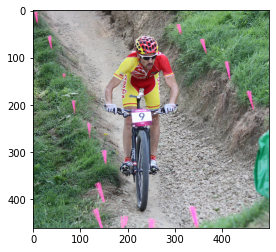

In [ ]:
import matplotlib.pyplot as pt

img = pt.imread(labels.indices[1])
pt.imshow(img)

print(labels.labels[1])